<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC2</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Transformers

En esta práctica introduciremos el modelo de aprendizaje profundo basado en _transformer_ y lo aplicaremos en dos problemas relacionados con el procesamiento de lenguage natural. 

<u>Consideraciones generales</u>: 

- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

# 0. Introducción
Esta PEC constará de dos ejercicios independientes: 
- En el primero se aplicarán los modelos de transformers a un problema de análisis de sentimiento en textos cortos de twitter,
- En el segundo ejercicio se aplicará este tipo de algorítmos para entrenar un traductor de inglés a francés.

La PEC se puede ejecutar en GPU (opción preferente) o en CPU. Como referencia, el apartado computacionalmente más costoso puede tardar alrededor un par de horas en un computador moderno con un chip i7 reciente. En cualquier caso, estos tiempos meramente orientativos y dependerán de la implementación y del hardware disponible.

# 1. Carga y preprocesado de la base de datos Sentiment 140 (2 puntos)
La base de datos [Sentiment 140](https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf) se compone de más de 1 millón de tweets que se han clasificado en función de si el mensaje es negativo (0) o positivo (4). El dataset se puede descargar desde la página de kaggle dedicada a ello:
- https://www.kaggle.com/datasets/kazanova/sentiment140

El objetivo de este ejercicio es entrenar un modelo que, dada una frase cualquiera, sea capaz de predecir si el mensaje es negativo o positivo. Las etapas del ejercicio serán las siguientes:
* Carga, preprocesado, exploración y visualización de los datos. 
* Entrenamiento de un modelo tradicional basado en una RNN o LSTM.
* Entrenamiento de una red que incluya Transformers.
* Optimización automática de los hyperparámetros del Transformer.
* Escalado de la arquitectura y mejora de los resultados. 


In [1]:
import pandas as pd
import numpy as np
import zipfile
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
import optuna
import pathlib
import random
import string
import re
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from IPython.display import clear_output
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.model_selection import train_test_split
import plotly.express as px
from nltk.corpus import stopwords

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1.1. Carga y visualizacion de los datos (2 puntos)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Descarga la base de datos, cargalá con Python, aleatoriza el orden de las filas del dataset y realiza un histograma del número de tweets positivos y tweets negativos.</p>
</div>

In [2]:
# Cargar el conjunto de datos Sentiment 140
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1', header=None)

# Asignar nombres de columna
df.columns = ["target", "ids", "date", "flag", "user", "text"]

# Aleatorizar el orden de las filas
df = df.sample(frac=1).reset_index(drop=True)

# Mostrar los primeros datos
df.head()

,target,ids,date,flag,user,text
0,4,1962417051,Fri May 29 11:00:49 PDT 2009,NO_QUERY,THISISRUSSIA,#Follow Friday @montill @djaaries @karimaDaCro...
1,0,2058406505,Sat Jun 06 14:52:46 PDT 2009,NO_QUERY,janetski,"@kirstiealley hollands' here too, but u just k..."
2,4,1956002572,Thu May 28 21:00:23 PDT 2009,NO_QUERY,micahlynnr,just booked a flight to detroit to meet the bf...
3,0,2256762264,Sat Jun 20 13:15:57 PDT 2009,NO_QUERY,Karayna,Stephanie Sun's songs always make me feel so s...
4,4,2064671862,Sun Jun 07 06:53:13 PDT 2009,NO_QUERY,Beeccaax3,On the bus


4    800000
0    800000
Name: target, dtype: int64


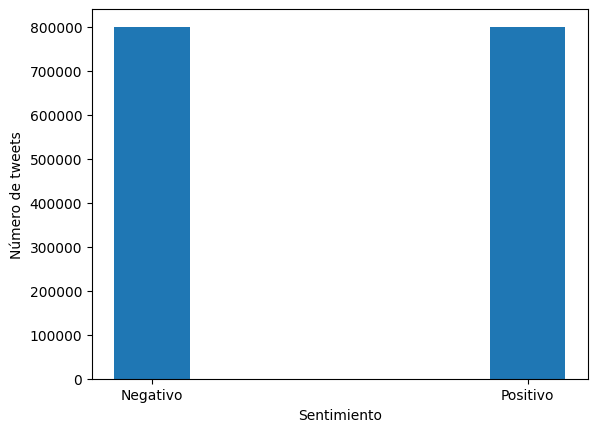

In [3]:
# contar el número de tweets positivos y negativos
counts = df['target'].value_counts()
print(counts)

# crear el histograma
plt.bar(counts.index, counts.values)
plt.xlabel('Sentimiento')
plt.ylabel('Número de tweets')
plt.xticks([0, 4], ['Negativo', 'Positivo'])
plt.show()

## 1.2. Visualización de los tweets y procesado del texto

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Muesta 5 tweets distintos, comprobarás que aparecen símbolos de puntuación, palabras en minúsculas o mayúsculas, etc. Realiza una limpieza y estandarización preliminar de todo el texto y luego cuenta las veces que aparece cada palabra y ordenálas. A la palabra que más veces aparece se le asigna el número 1, la siguiente el 2, etc. Representa en escala logarítmica la frequencia de apareción versus el número asignado.</p>
</div>

In [4]:
# Mostrar 5 tweets distintos
print("Mostrar 5 tweets distintos originales")
print(df["text"].sample(5))

Mostrar 5 tweets distintos originales
1256442    3852 songs down, only 148 left. It only took m...
136055     @Mayra326 aww, have fun!  I just had my 3D las...
596802     is soooo tired after a busy weekend with becky...
828385     @KimBlairwitch - no sorry, busy editing anothe...
538031                   at the #Vodafone #MobileWidgetCamp 
Name: text, dtype: object


In [5]:
# Importamos los StopWords y añadimos otros signos
stop_words = stopwords.words('english')
stop_words = [re.sub(r'[^a-zA-Z ]+', '', x) for x in stop_words]

# Función para limpiar texto
def limpieza_estandarizacion(texto):
    texto = re.sub(r'[^a-zA-Z ]+', '', texto).lower().split(" ")
    texto_filtrado = [palabra for palabra in texto if palabra not in stop_words]
    
    return (" ").join(texto_filtrado)

In [6]:
# Aplicar la función de limpieza al texto
df['text'] = df['text'].apply(lambda x: limpieza_estandarizacion(x))

In [7]:
# Mostrar 5 tweets distintos limpios
print("\n\nMostrar 5 tweets distintos limpios")
print(df["text"].sample(5))



Mostrar 5 tweets distintos limpios
30338      techau clicked link top right bing front page ...
1314097                           window shopping internets 
463252                                      wish california 
169705                                          ihaveissues 
283707             homeward bound open road  beautiful fave 
Name: text, dtype: object


In [8]:
# Contar las palabras y ordenarlas
serie = df.text.str.split(expand=True).stack().value_counts().to_frame()
serie['numero'] = serie.reset_index().index+1
serie.head()

,0,numero
im,178365,1
good,89420,2
day,84818,3
get,81599,4
like,77780,5


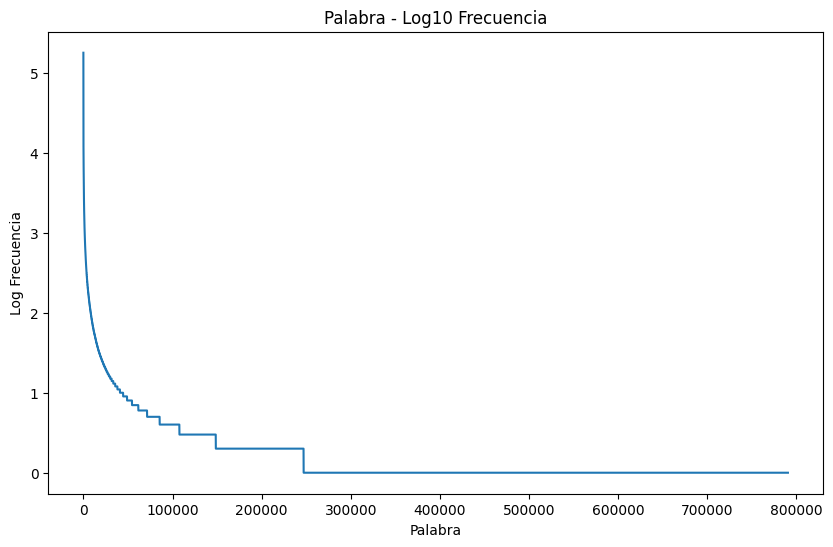

In [9]:
# Representar la frecuencia de aparición en escala logarítmica
plt.figure(figsize=(10,6))
plt.plot(serie['numero'], 
         [np.log10(word) for word in serie[0]])
plt.xlabel("Palabra")
plt.ylabel("Log Frecuencia")
plt.title("Palabra - Log10 Frecuencia")
plt.show()

## 1.3. Procesado de las etiquetas y tokenización

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Como habrás observado, el lenguaje natural está muy desbalanceado, unas pocas palabras aparecen muchas veces y muchas palabras aparecen en pocas ocasiones. Esta información la tendremos en cuenta para construir posteriormente nuestros vocabulario de tokens, descartando palabras que aparecen poco.
    
Ahora nos vamos a quedar únicamente 20000 frases de todo el dataset. Las etiquetas han de ser convertidas al formato adecuado y se procesaran los textos para obtenerlos en forma de tokens con la función Tokenizer de Tensorflow. Muestra un ejemplo de una frase tokenizada y decodificada de nuevo.

</div>

In [10]:
# Seleccionar 20000 frases
df_lite = df.sample(20000).reset_index().copy()
df_lite.head()

,index,target,ids,date,flag,user,text
0,54479,4,2001042508,Mon Jun 01 23:40:30 PDT 2009,NO_QUERY,iamvenice,uploading music multiply account love ladygaga...
1,1066087,4,1753789783,Sun May 10 03:27:49 PDT 2009,NO_QUERY,sugardayfox,launch make break alpha phase residential rea...
2,24101,0,1759420222,Sun May 10 19:10:23 PDT 2009,NO_QUERY,mari8790,headache happy mothers day last night iiinsane
3,844592,0,2063238467,Sun Jun 07 01:52:44 PDT 2009,NO_QUERY,emeelgoesww,tabbytabby uhm well nl wed come back arhus sat...
4,154947,0,2298234552,Tue Jun 23 11:25:26 PDT 2009,NO_QUERY,iluvoltl,watching oltl think starr cloe r


In [11]:
# Convertir etiquetas
df_lite['target'] = df_lite['target'].apply(lambda x: 1 if x==4 else 0)

In [12]:
# Tokenizar textos
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_lite['text'])
sequences = tokenizer.texts_to_sequences(df_lite['text'])

# Mostrar ejemplo
ej = random.randint(0, len(df_lite)-1)
example = sequences[ej]
print("Texto original: ", df_lite['text'].iloc[ej])
print("Texto tokenizado: ", example)
print("Texto decodificado: ", tokenizer.sequences_to_texts([example]))

Texto original:  epikurean sweet ill sure catch seen hp films imax 
Texto tokenizado:  [14444, 273, 34, 96, 530, 263, 3226, 3056, 14445]
Texto decodificado:  ['epikurean sweet ill sure catch seen hp films imax']


## 1.4. Partición de los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Finalmente deja un 80% de los datos para train y el resto para test. Únicamente se utilizaran 3000 tokens distintos.</div>

Utiliza la función `tf.keras.utils.pad_sequences` para normalizar el tamaño de todas los mensajes tokenizados. El tamaño final será el tamaño del mensaje más largo. Muestra un ejemplo de una frase una vez que se ha aplicado esta función.

In [13]:
# Calcular los índices para cada subconjunto
train_index = int(len(df_lite) * 0.8)

# Dividir los datos en los subconjuntos
xl = df_lite['text']
yl = df_lite['target']
X_train = xl[:train_index]
X_test = xl[train_index:]
y_train = yl[:train_index]
y_test = yl[train_index:]

# Crea el Tokenizer
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train)

# Tokeniza los textos
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Normaliza la longitud de los mensajes
maxlen  = max([len(x) for x in X_train_seq])
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=maxlen , padding='post')
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=maxlen , padding='post')

In [14]:
# Muestra un ejemplo de una frase una vez que se ha aplicado la función pad_sequences
print('Texto original:\n', X_train.iloc[0])
print('\nTexto tokenizado:\n', X_train_seq[0])
print('\nTexto tokenizado y normalizado:\n', X_train_seq_padded[0])
print("Texto decodificado: ", tokenizer.sequences_to_texts([X_train_seq[0]]))

Texto original:
 uploading music multiply account love ladygagas music 

Texto tokenizado:
 [1336, 162, 678, 9, 162]

Texto tokenizado y normalizado:
 [1336  162  678    9  162    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Texto decodificado:  ['uploading music account love music']


# 2. Clasificación de tweets (4 puntos)

## 2.1 Entrenando el modelo con una RNN o LSTM




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Utilizando los conocimientos adquiridos hasta ahora, entrenar un modelo de análisis de sentimientos con con una RNN o LSTM. Se proporciona la capa de entrada para facilitar el procesado de los tokens. Representar la accuracy durante el entrenamiento y durante la validación.
Varía los parámetros o la configuración de la red para mejorar el resultado. Finalmente, muestra el mejor resultado obtenido sobre test.
</div>


In [15]:
# Esta capa se proporciona para facilitar la tarea.
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [16]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

#------------------------------#
#     CLASES COGIDAS PEC2      #
#------------------------------#

class TimerCallback(Callback):
    def __init__(self):
        self.start_time = None
        self.epoch_times = []
        
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time
        self.epoch_times.append(epoch_time)
        print(f"Época {epoch+1} - Tiempo transcurrido: {epoch_time:.2f} segundos")
        
    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        print(f"Entrenamiento completado en {total_time:.2f} segundos")
        print(f"Tiempo promedio por época: {sum(self.epoch_times) / len(self.epoch_times):.2f} segundos")
        
    def plot_epoch_times(self):
        fig, ax = plt.subplots()
        ax.plot(range(len(self.epoch_times)), self.epoch_times)
        ax.set_xlabel("Época")
        ax.set_ylabel("Tiempo (s)")
        ax.set_title("Historial de tiempo de época")
        plt.show()
        
    def get_total_time(self):
        return time.time() - self.start_time
    
    
    
class PlotLearning(Callback):
    """
    Callback para plotear las métricas durante el entrenamiento.
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                   # podemos elegir si mostrar o no el plot del learning rate en cada epoch

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [23]:
# Definir los parámetros del modelo
maxlen = max([len(x) for x in X_train_seq])
vocab_size = 3000
embed_dim = 128
lstm_size = 64
batch_size = 32
epochs = 100

In [34]:
# Crear la capa de entrada del modelo
inputs = layers.Input(shape=(maxlen,))

# Crear una capa de embedding
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

# Crear una capa LSTM
x = layers.LSTM(64, return_sequences=True)(x)

# Crear una capa LSTM
x = layers.LSTM(128, return_sequences=True)(x)

# Añadir Dropout
x = layers.Dropout(0.2)(x)

# Añadir una capa densa para clasificar la salida
outputs = layers.Dense(1, activation='sigmoid')(x)

# Crear el modelo
model = keras.Model(inputs=inputs, outputs=outputs)

In [35]:
# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [36]:
# Definición de callbacks
timer_cb = TimerCallback()
plot_cb = PlotLearning()
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

callbacks = [timer_cb, plot_cb, earlystop_cb, reducelr_cb]

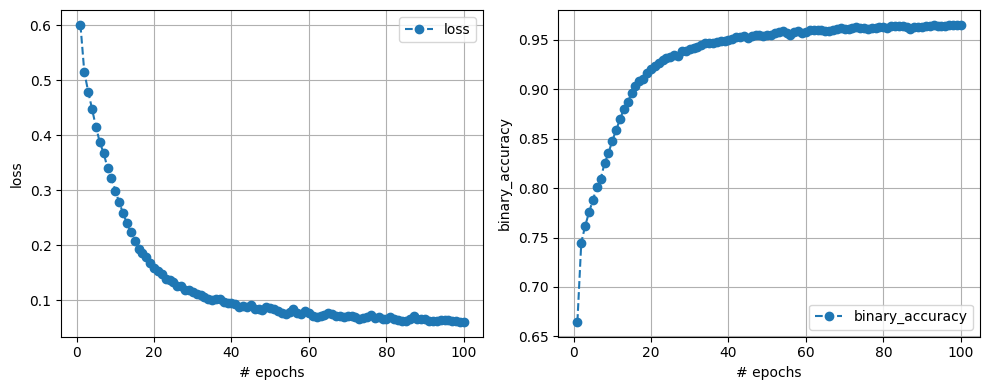

500/500 [==============================] - 4s 7ms/step - loss: 0.0609 - binary_accuracy: 0.9653 - lr: 0.0010
Entrenamiento completado en 409.96 segundos
Tiempo promedio por época: 217.80 segundos


In [37]:
history = model.fit(X_train_seq_padded, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks)

In [38]:
# Evaluación del modelo
loss, acc = model.evaluate(X_test_seq_padded, y_test)
print("Loss en test:", loss)
print("Precisión en test:", acc)

125/125 [==============================] - 1s 3ms/step - loss: 3.5112 - binary_accuracy: 0.6407
Loss en test: 3.5111818313598633
Precisión en test: 0.6406974196434021


## 2.2 Construye una red con dos capas de atención y entrena el modelo de nuevo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Implementar una arquitectura basada en capas de atención que tendrá la siguiente estructura:
    
* La entrada primero se convierte a posicional embeddings con la función proporcionada TokenAndPositionEmbedding.
* Después habrá una capa MultiHeadAttention, seguida de un dropout y normalizacion
* Se añade otra capa MultiHeadAttention, seguida de un dropout y normalizacion.
* Despues añadir dos redes full connected, la primera con 32 neuronas y la segunda con 16.
* Finalmente añadir una capa de normalizacion, un droput, una capa de GlobalAveragePooling1D
    
Los dropouts serán del 20%, el numero de cabezas de la red Multihead será de 6


In [24]:
class Transformer(layers.Layer):
    def __init__(self, sizedense, sizedense2, num_heads):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.attention_layer1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout_layer1 = layers.Dropout(0.2)
        self.normalization_layer1 = layers.LayerNormalization(epsilon=1e-6)
        self.attention_layer2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout_layer2 = layers.Dropout(0.2)
        self.normalization_layer2 = layers.LayerNormalization(epsilon=1e-6)
        self.dense_layer1 = layers.Dense(sizedense, activation="relu")
        self.dense_layer2 = layers.Dense(sizedense2, activation="relu")
        self.normalization_layer3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_layer3 = layers.Dropout(0.2)
        self.pooling_layer = layers.GlobalAveragePooling1D()
        self.dense_output = layers.Dense(1, activation="sigmoid")

    def call(self, inputs, training):
        x = self.embedding_layer(inputs)
        x = self.attention_layer1(x, x)
        x = self.dropout_layer1(x, training=training)
        x = self.normalization_layer1(x)
        x = self.attention_layer2(x, x)
        x = self.dropout_layer2(x, training=training)
        x = self.normalization_layer2(x)
        x = self.dense_layer1(x)
        x = self.dense_layer2(x)
        x = self.normalization_layer3(x)
        x = self.dropout_layer3(x, training=training)
        x = self.pooling_layer(x)
        output = self.dense_output(x)
        return output

sizedense = 32
sizedense2 = 16
num_heads = 6

# Input
inputs = layers.Input(shape=(maxlen,))

# Create the Transformer model
transformer_model = Transformer(sizedense, sizedense2, num_heads)

# Obtain the output
outputs = transformer_model(inputs, training=False)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Entrena el modelo anterior probando distintos batch sizes, evitando el overfitting y reportando las metricas de loss y accuracy durante el entrenamiento. Muestra finalmente el mejor resultado obtenido y comenta los resultados en comparación con los obtenidos anteriormente.

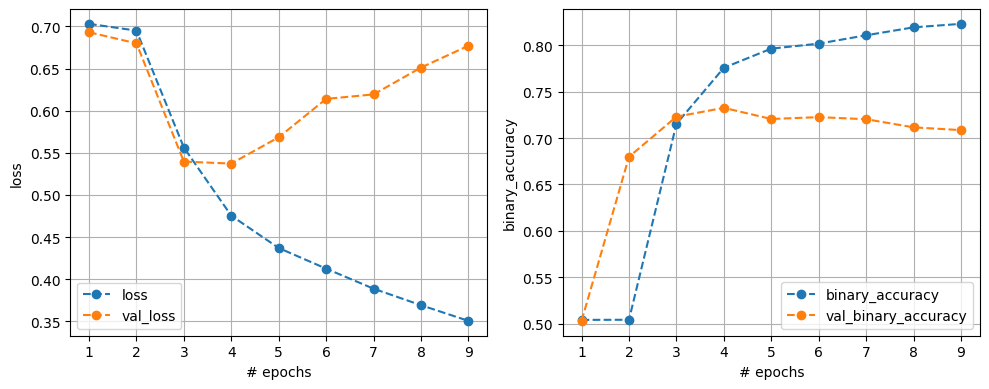

125/125 [==============================] - 2s 19ms/step - loss: 0.3505 - binary_accuracy: 0.8230 - val_loss: 0.6771 - val_binary_accuracy: 0.7085 - lr: 0.0010
Entrenamiento completado en 41.83 segundos
Tiempo promedio por época: 30.51 segundos
125/125 [==============================] - 1s 4ms/step - loss: 0.5372 - binary_accuracy: 0.7325

Mejor resultado obtenido con tamaño de batch 32:
Exactitud en el conjunto de validación: 0.7380


In [40]:
# Función para entrenar el modelo
def train_model(model, X_train, y_train, X_val, y_val, batch_size, epochs):
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
    
    # Definición de callbacks
    timer_cb = TimerCallback()
    plot_cb = PlotLearning()
    earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    callbacks = [timer_cb, plot_cb, earlystop_cb, reducelr_cb]

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=callbacks
    )

    return history

# Parámetros de entrenamiento
batch_sizes = [32, 64, 128]
epochs = 100

# Listas para almacenar los resultados
histories = []
val_accuracies = []

# Entrenamiento con diferentes tamaños de batch
for batch_size in batch_sizes:
    print(f"\nEntrenando con tamaño de batch: {batch_size}")
    # Crear una nueva instancia del modelo
    transformer_model = Transformer(sizedense, sizedense2, num_heads)
    model = tf.keras.Model(inputs=inputs, outputs=transformer_model(inputs))
    
    # Entrenar el modelo
    history = train_model(model, X_train_seq_padded, y_train, X_test_seq_padded, y_test, batch_size, epochs)
    histories.append(history)

    # Evaluar el modelo en el conjunto de validación
    _, val_accuracy = model.evaluate(X_test_seq_padded, y_test)
    val_accuracies.append(val_accuracy)

# Obtener el mejor resultado
best_index = np.argmax(val_accuracies)
best_batch_size = batch_sizes[best_index]
best_history = histories[best_index]
best_val_accuracy = val_accuracies[best_index]

print(f"\nMejor resultado obtenido con tamaño de batch {best_batch_size}:")
print(f"Exactitud en el conjunto de validación: {best_val_accuracy:.4f}")

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>  
Cuando variamos el batch_size nos damos cuenta de que la precisión no varia mucho de uno a otro, pero el mejor ha sido cuando se ha aplicado uno de 32, obteniendo una precisión del 73,8%, lo que es bastante alta para este tipo de problemas.

Si comparamos esta precisión con la del modelo LSTM (que es del 64,06%) nos damos que un modelo basado en Transformers es más eficiente.  
<br><br>
</div>

## 2.3. Búsqueda de hyperparámetros de la red

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Vamos a automatizar la busqueda de hyperparametros mediante un grid search. Para ello vamos a tomar como hyperparámetros el número de heads, el batch size y el número de neuronas de la red fully conected. Para cada uno de estos hyperparámetros elige varios valores representativos y entrena un modelo para cada una de las combinaciones. Como el entrenamiento de la red neuronal no es totalmente determinista y se ha restringido el númerode datos, entrena para la misma configuración al menos 5 modelos y guarda la media del mejor accuracy. Haz una representación gráfica <strong>adecuada y explicativa</strong> con la combinacion de hyperparámetros versus resultados.
    
La búsqueda de hiperaparámetros y la representación se pueden realizar de forma manual y con librerías habituales o bien utilizar implementaciones específicas para ello como la librería optuna. Si se utiliza está librería se puede realizar una búsqueda bayesiana (sugerencia opcional) de los hiperparámetros en vez de un simple grid search.
    
Comenta los resultados.
</div>


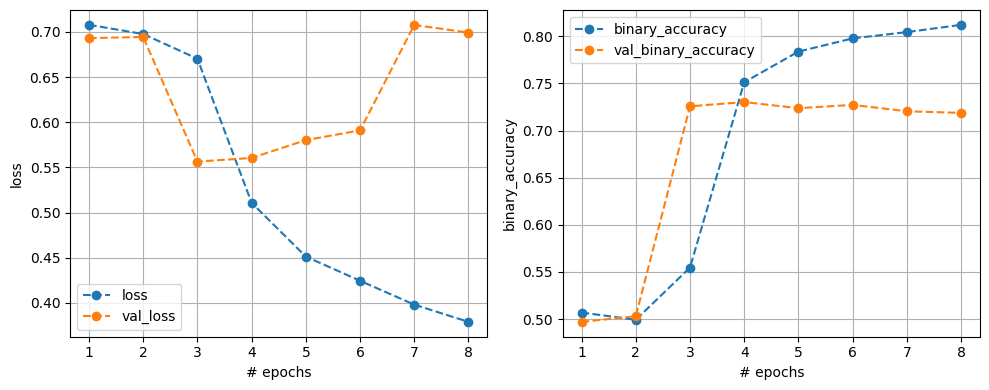

125/125 [==============================] - 18s 147ms/step - loss: 0.3790 - binary_accuracy: 0.8122 - val_loss: 0.6994 - val_binary_accuracy: 0.7188 - lr: 0.0010
Entrenamiento completado en 129.31 segundos
Tiempo promedio por época: 73.22 segundos
125/125 [==============================] - 27s 210ms/step - loss: 0.5565 - binary_accuracy: 0.7258


In [42]:
# Parámetros de entrenamiento
batch_sizes = [32, 64, 128]
nums_heads = [6, 8, 10]
nums_neur = [(8,16),(16,32),(32,64)]
epochs = 50
num_runs = 5  # Número de ejecuciones para cada configuración

# Listas para almacenar los resultados
histories = []
b_s = []
n_h = []
n_n = []
val_accuracies = []

# Entrenamiento con diferentes tamaños de batch
for batch_size in batch_sizes:
    for num_h in nums_heads:
        for num_n in nums_neur:
            print(f"\nEntrenando con tamaño de batch: {str(batch_size)}")
            print(f"\nEntrenando con tamaño de heads: {str(num_h)}")
            print(f"\nEntrenando con tamaño de neuronas 1: {str(num_n[0])}")
            print(f"\nEntrenando con tamaño de neuronas 2: {str(num_n[1])}")
            b_s.append(batch_size)
            n_h.append(num_h)
            n_n.append(num_n)
            
            accuracies = []  # Lista para almacenar los resultados de accuracy para cada ejecución
            
            for _ in range(num_runs):
                # Crear una nueva instancia del modelo
                transformer_model = Transformer(num_n[0], num_n[1], num_h)
                model = tf.keras.Model(inputs=inputs, outputs=transformer_model(inputs))

                # Entrenar el modelo
                history = train_model(model, X_train_seq_padded, y_train, X_test_seq_padded, y_test, batch_size, epochs)
                histories.append(history)

                # Evaluar el modelo en el conjunto de validación
                _, val_accuracy = model.evaluate(X_test_seq_padded, y_test)
                accuracies.append(val_accuracy)
            
            avg_best_accuracy = np.mean(np.max(accuracies))  # Promedio del mejor accuracy obtenido de las ejecuciones
            val_accuracies.append(avg_best_accuracy)


In [47]:
# Creamos una tabla con todos los resultados
hiperparameters = pd.DataFrame(list(zip(b_s, n_h, n_n, val_accuracies)), columns =['batch_size','num_heads','num_neur','val_accuracies'])

hiperparameters['num_neur_1'], hiperparameters['num_neur_2'] = zip(*hiperparameters.num_neur)
del hiperparameters['num_neur']

hiperparameters.sort_values(by=['val_accuracies'], ascending=False).head()

,batch_size,num_heads,val_accuracies,num_neur_1,num_neur_2
23,128,8,0.73775,32,64
20,128,6,0.73575,32,64
24,128,10,0.73525,8,16
8,32,10,0.73475,32,64
3,32,8,0.73450,8,16


In [48]:
# Representación gráfica adecuada y explicativa con la combinacion de hyperparámetros versus resultados.
h = hiperparameters[['batch_size','num_heads','num_neur_1','num_neur_2','val_accuracies']]

fig = px.parallel_coordinates(h, color="val_accuracies", labels={"batch_size": "Batch",
                "num_heads": "heads", "num_neur_1": "neuronas_1",
                "num_neur_2": "neuronas_2", "val_accuracies": "Precisión", },
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=0.68)
fig.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Para la búsqueda de hiperparametros para el modelo anterior, he usado una búsqueda iterativa probando con varios parámetros representativos. Como se puede comprobar en la tabla anterior (donde se muestra el top de los 5 mejores) y en la gráfica la variación de precisión no cambia mucho, no obstante, la mejor combinación ha sido con un batch_size de 128, usando 8 hilos, y los tamaños de las neuronas de 64 y 32 respectivamente.  
<br><br>
</div>

## 2.4. Escala los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Ahora entrena el modelo con todos los datos disponibles (dejando un 80% para train y un 20% para test) con los mejores hyperparámetros identificados. Muestra además del mejor resultado, las gráficas de accuracy y loss durante el entrenamiento.
    
Comenta los resultados
</div>


In [17]:
# Mostramos algunos datos del conjunto completo
df.head()

,target,ids,date,flag,user,text
0,4,1962417051,Fri May 29 11:00:49 PDT 2009,NO_QUERY,THISISRUSSIA,follow friday montill djaaries karimadacrop fw...
1,0,2058406505,Sat Jun 06 14:52:46 PDT 2009,NO_QUERY,janetski,kirstiealley hollands u keep ignoring fact ho...
2,4,1956002572,Thu May 28 21:00:23 PDT 2009,NO_QUERY,micahlynnr,booked flight detroit meet bfs parents june th...
3,0,2256762264,Sat Jun 20 13:15:57 PDT 2009,NO_QUERY,Karayna,stephanie suns songs always make feel sad sti...
4,4,2064671862,Sun Jun 07 06:53:13 PDT 2009,NO_QUERY,Beeccaax3,bus


In [18]:
# Convertir etiquetas
df['target'] = df['target'].apply(lambda x: 1 if x==4 else 0)

In [19]:
# Calcular los índices para cada subconjunto
train_index = int(len(df) * 0.8)

# Dividir los datos en los subconjuntos
xl = df['text']
yl = df['target']
X_train = xl[:train_index]
X_test = xl[train_index:]
y_train = yl[:train_index]
y_test = yl[train_index:]

In [26]:
# Crea el Tokenizer
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train)

# Tokeniza los textos
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Normaliza la longitud de los mensajes
maxlen  = max([len(x) for x in X_train_seq])

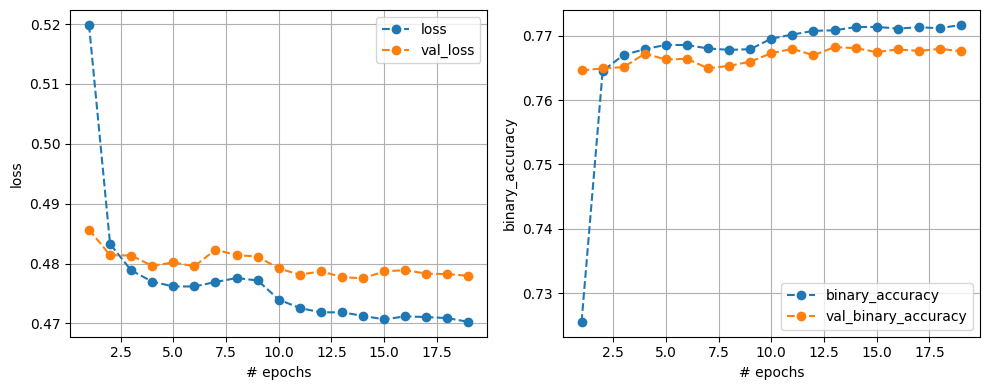

10000/10000 [==============================] - 177s 18ms/step - loss: 0.4703 - binary_accuracy: 0.7717 - val_loss: 0.4780 - val_binary_accuracy: 0.7676 - lr: 5.0000e-04
Entrenamiento completado en 3448.60 segundos
Tiempo promedio por época: 1834.98 segundos


In [29]:
# Creamos el nuevo modelo con los Hiperparametros
inputs = layers.Input(shape=(maxlen,))

X_train_seq_padded = pad_sequences(X_train_seq, maxlen=maxlen , padding='post')
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=maxlen , padding='post')

transformer_model = Transformer(32, 64, 8) # Añadimos los valores de Hiperparametros
model = tf.keras.Model(inputs=inputs, outputs=transformer_model(inputs))

# Entrenamos el modelo
history = train_model(model, X_train_seq_padded, y_train, X_test_seq_padded, y_test, 128, 100)

In [31]:
# Evaluación del modelo
loss, acc = model.evaluate(X_test_seq_padded, y_test)
print("Loss en test:", loss)
print("Precisión en test:", acc)

10000/10000 [==============================] - 56s 6ms/step - loss: 0.4775 - binary_accuracy: 0.7681
Loss en test: 0.4775322377681732
Precisión en test: 0.7681093811988831


10000/10000 [==============================] - 27s 3ms/step


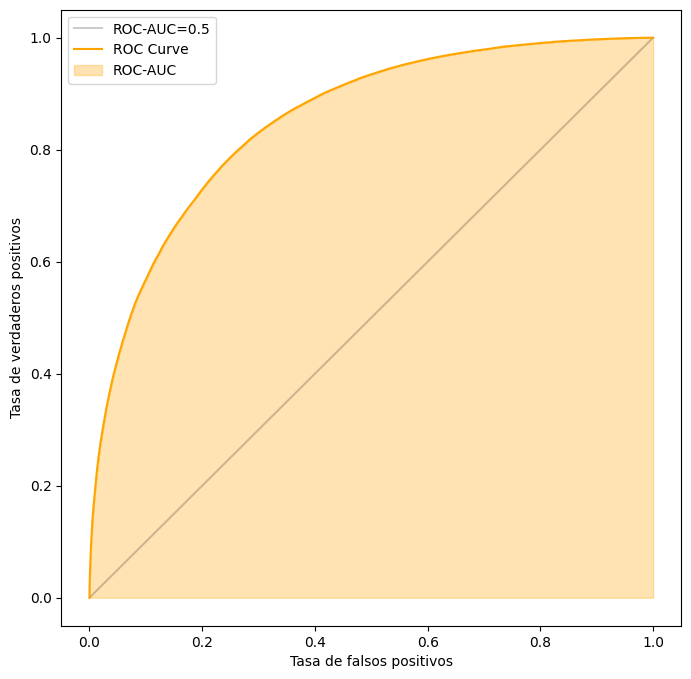

In [33]:
# Predicción del modelo
y_pred = model.predict(X_test_seq_padded)

fprs, tprs, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], linestyle="-", c="k", alpha=0.2, label="ROC-AUC=0.5")
plt.plot(fprs, tprs, color="orange", label="ROC Curve")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")

y_zeros = [0 for _ in tprs]
plt.fill_between(fprs, y_zeros, tprs, color="orange", alpha=0.3, label="ROC-AUC")
plt.legend()
plt.show()

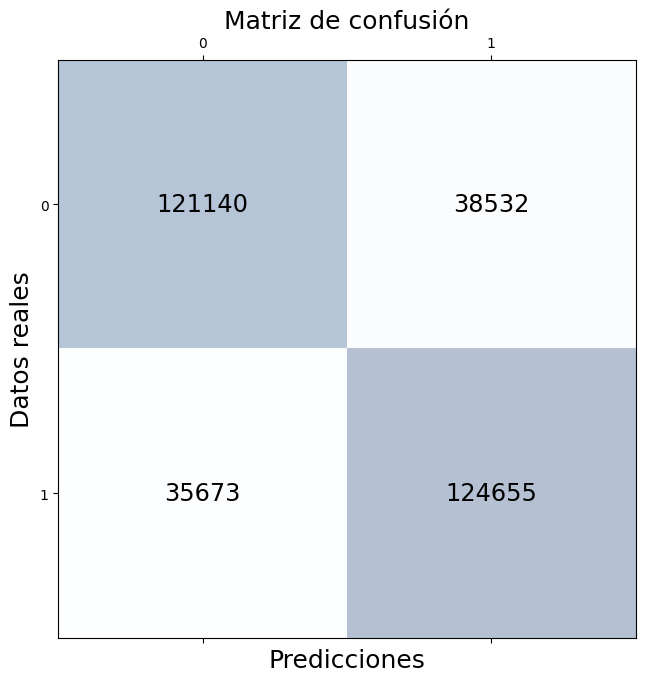

In [34]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, [0 if x < 0.5 else 1 for x in y_pred])

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predicciones', fontsize=18)
plt.ylabel('Datos reales', fontsize=18)
plt.title('Matriz de confusión', fontsize=18)
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
Ahora al escalar los datos, y usar los hiperparmetros, vemos que la precisión del modelo es del 76,81%, lo cual ha subido el nivel de precisión un 3% respecto al anterior modelo, en donde solo hemos probados con distintos batch_size.
    
En conclusión, para este tipo de problemas, se ha conseguidor crear una modelo con una arquitectura Transformers y se ha obtenido una precisión bastante buena. 
<br><br>
</div>

## 2.5. Extra 
Al tratarse Sentiment140 de un dataset público es habitual que los investigadores, equipos de data scientist o miembros de la comunidad de la ciencia de datos reporten los resultados obtenidos con sus nuevos algorítmos. En los últimos años se ha hecho popular una página web que reporta los resultados obtenidos por diferentes equipos junto con código reproducible: https://paperswithcode.com/sota/text-classification-on-sentiment140


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0 pt.]:</strong> Este apartado es un ejercicio extra que no es obligatorio realizar. Se trata de explorar los resultados reportados en la url indicada. Comprobarás que los resultados obtenidos están basados en modelos de lenguage de gran tamaño finetuneados sobre el dominio. Se anima al alumno a probar a cambiar la arquitectura utilizada o a utilizar alguno de los modelos y finetunearlo sobre el dominio con la ayuda de librerías como huggingface e intentar obtener resultados que se acerquen (¿o supéren?) a los benchmarks reportados.
</div>

In [ ]:
## Apartado extra opcional.

# 3. Ejercicio sobre traducción de textos (4 puntos)
En esta segunda parte vamos a utilizar una base de datos distinta para mostrar uno de los problemas en los que las arquitecturas basadas en transformers son más potentes: la conversión de secuencias a secuencias. En este caso lo vamos a entender como una traducción de un idioma a otro, pero esto es generalizable. Arquitecturas similares se podrían utilizar para convertir una secuencia larga (texto) a una secuencia (resumen), para reducir la complejidad de lectura de un texto, para transcribirlo a lenguaje de signos, etc.

## 3.1 Importación de los datos y preprocesamiento previo
En este caso la base de datos que se va a utilizar es la llamada WMT2014 English-French que contiene frases traducidas entre inglés y frances. 
Los datos se pueden descargar de:
https://paperswithcode.com/sota/machine-translation-on-wmt2014-english-french

Se trata de un fichero enorme. Por ello únicamente se van a utilzar un fragmento de todos los pares de frases del fichero. Se recomienda no cargar todos los datos simultaneamente para evitar problemas de memoria y de tiempo de computación.




<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong></p> Al igual que en casos anteriores, el primer paso es cargar y preprocesar los datos de la forma adecuada. Para ello se pide:
    
* Cargar las primeras 100.000 lineas del dataset proporcionado.
* Procesar el dataset de forma que se obtenga una lista de tuplas. El primer elemento de la tupla es la frase en inglés, el segundo elemento es la frase en frances. Al comienzo y final de la frase objetivo hay que añadir un caracter especial de comienzo [start] y fin de frase [end]: e.g. [start] lle découle de notre étonnement [end]
* Limpiar los datos de caracteres extraños, pasar a minusculas, etc.
* Mostrar varios pares de frases para comprobar que está correctamente procesado
* Toma al azar un 80% de los datos como train y el resto como test
* Comprueba que tus datos se llaman train_data y test_data  tienen la forma [(frase ingles, frase francés), (frase ingles,frase francés))  
* Ejecuta la celda que se ha proporcionado para vectorizar y codificar los datos.

</div>

In [36]:
# Cargamos los datos
df = pd.read_csv('/kaggle/input/en-fr-translation-dataset/en-fr.csv', encoding='utf-8', header = 0, nrows=100000)
df.head()

,en,fr
0,Changing Lives | Changing Society | How It Wor...,Il a transformé notre vie | Il a transformé la...
1,Site map,Plan du site
2,Feedback,Rétroaction
3,Credits,Crédits
4,Français,English


In [37]:
# Comprobamos si no existen nulos
df = df[df['en'].notnull()]
df = df[df['fr'].notnull()]

In [38]:
# Procesar los datos
def limpieza_estandarizacion_ampliado(texto, idioma):
    try:
        texto = re.sub(r'[^a-zA-Z\u00C0-\u00FF ]+', '', texto).lower().split(" ")
        """
        if idioma == 'en':
            stop_words = stopwords.words('english')
        elif idioma == 'fr':
            stop_words = stopwords.words('french')
        texto_filtrado = [palabra for palabra in texto if palabra not in stop_words]
        """
        return (" ").join(texto)
        
    except: 
        return (" ").join('')


df['en'] = df['en'].apply(lambda x: limpieza_estandarizacion_ampliado(x, 'en'))
df['fr'] = df['fr'].apply(lambda x: limpieza_estandarizacion_ampliado(x, 'fr'))

In [39]:
# Añadimos caracteres especiales
def f(english, french):
    return (f'{english}', f'[start] {french} [end]' )

df['procesado'] = df.apply(lambda x: f(x.en, x.fr), axis=1)

In [40]:
# Mostrar datos procesados
df.head()

,en,fr,procesado
0,changing lives changing society how it works...,il a transformé notre vie il a transformé la ...,(changing lives changing society how it work...
1,site map,plan du site,"(site map, [start] plan du site [end])"
2,feedback,rétroaction,"(feedback, [start] rétroaction [end])"
3,credits,crédits,"(credits, [start] crédits [end])"
4,français,english,"(français, [start] english [end])"


In [61]:
# Calcular los índices para cada subconjunto
train_index = int(len(df['procesado']) * 0.8)

# Dividir los datos en los subconjuntos
xl = df['procesado']
train_data = xl[:train_index]
test_data = xl[train_index:]

In [62]:
# Mostrar el tamaño de train_data, test_data y val_data
print(f"Tamaño de train_data: {len(train_data)}")
print(f"Tamaño de test_data: {len(test_data)}")

Tamaño de train_data: 79999
Tamaño de test_data: 20000


In [63]:
###########################################################
# Esta celda para vectorizar los datos se propociona ######
###########################################################

vocab_size = 15000
sequence_length = 20
batch_size = 64

eng_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,)
fr_vectorization = TextVectorization(max_tokens=vocab_size,output_mode="int",output_sequence_length=sequence_length + 1,)

train_eng_texts = [pair[0] for pair in train_data]
train_fr_texts = [pair[1] for pair in train_data]

eng_vectorization.adapt(train_eng_texts)
fr_vectorization.adapt(train_fr_texts)



def format_dataset(eng, fr):
    eng = eng_vectorization(eng)
    fr = fr_vectorization(fr)
    return ({"encoder_inputs": eng, "decoder_inputs": fr[:, :-1],}, fr[:, 1:])


def make_dataset(pairs):
    eng_texts, fr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fr_texts = list(fr_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_vectorized = make_dataset(train_data)
val_vectorized = make_dataset(test_data)

## 3.2. Modifica el bloque de transformer
A continuación se proporciona un bloque transformer del tipo seq2seq con un encoder y un decoder antes de la salida. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pts.]:</strong></p> Se propone realizar algunos cambios sobre la implementación del bloque transformer:
    
* Añade una capa de atención de una sola cabeza al final del encoder.
* Añade una capa fully connected en el encoder
* Duplica el bloque encoder
* Añade una capa de dropout despues del bloque del decoder.

</div>

In [ ]:
########################################
# Codigo proporcionado #################
########################################
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(query=out_1,value=encoder_outputs,key=encoder_outputs,attention_mask=padding_mask,)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_1)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    
    
embed_dim = 128
latent_dim = 1024
num_heads = 2

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")


In [64]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.attention_2 = layers.MultiHeadAttention(num_heads=1, key_dim=embed_dim)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        att = self.attention_2(query=proj_input, value=proj_input, key=proj_input)
        proj_output = self.dense_proj(att)
        proj_output = self.dense_proj(proj_output)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(query=out_1,value=encoder_outputs,key=encoder_outputs,attention_mask=padding_mask,)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_1)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    
    
embed_dim = 128
latent_dim = 1024
num_heads = 2

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
y = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(y)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")

transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

## 3.3. Entrena el modelo


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Entrena el modelo mostrando las gráficas de loss y accuracy. La accuracy no es una métricas que habitualmente se utilice en el entrenamiento de modelos de traducción. Lo habitual en este tipo de problemas sería utilizar la métrica BLEU basada en n-gramas (https://en.wikipedia.org/wiki/BLEU). Sin embargo, el bleu no está nativamente disponible en tensorflow para compilar el modelo así que como referencia se utilizará el accuracy que sería equivalente a la métrica de BLEU considerándo únicamente n-gramas de tamaño 1.

In [65]:
# Definición de callbacks
timer_cb = TimerCallback()
plot_cb = PlotLearning()
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

callbacks = [timer_cb, plot_cb, earlystop_cb, reducelr_cb]

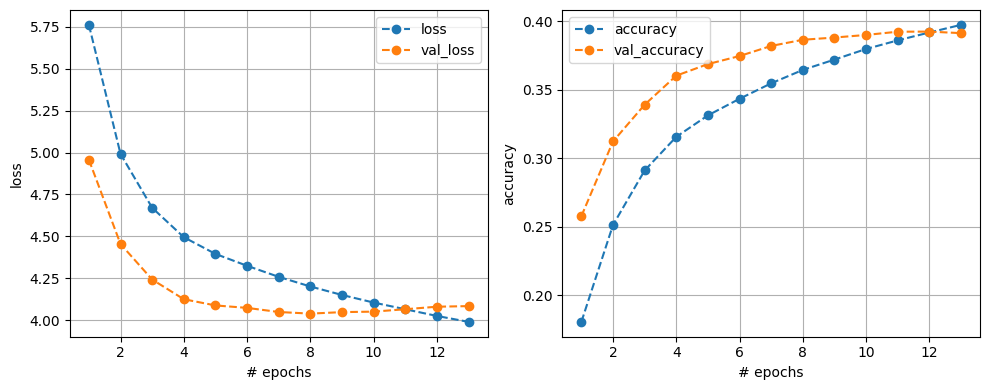

1250/1250 [==============================] - 71s 57ms/step - loss: 3.9909 - accuracy: 0.3975 - val_loss: 4.0848 - val_accuracy: 0.3914 - lr: 0.0010
Entrenamiento completado en 1115.63 segundos
Tiempo promedio por época: 652.09 segundos


In [66]:
history = transformer.fit(train_vectorized, epochs=50, validation_data=val_vectorized, callbacks=callbacks)

## 3.4. Realiza una predicción sobre el dataset de test.
El modelo transformer es regresivo, esto quiere decir que para hacer la predicción se utiliza tanto el input de entrada como las predicciones ya realizadas. De hecho, este es uno de los principales motivos de las alucinaciones que sufren los modelos basados en transformers. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Se proporciona una funcion para decodificar una frase con el modelo entrenado . Hacer las modificaciones oportunas e importar las funciones necesarias para calcular el Bleu score sobre un subconjunto del test, por ejemplo sobre 100 frases.

Finalmente realiza alguna mejora a tu elección para conseguir un modelo con mejor Bleu (comprobándolo). Se puede añadir más datos al train, modificar la arquitectura, variar los hiperparámetros, etc. Se sugiere modificar el  dropout a un valor más habitual en la literatura. 
    
Compara tus resultados con los que aparecen en la url de paperswithcode y comentalos.

In [86]:
###  Codigo proporcionado ############
fr_vocab = fr_vectorization.get_vocabulary()
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = fr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [108]:
# Define the number of sentences to evaluate
num_sentences = 100

# Function to calculate BLEU score
def calculate_bleu_score(data):
    references = []
    translations = []

    for i in range(num_sentences):
        input_sentence = data[i][0]  # English input sentence
        target_sentence = data[i][1]  # Target (reference) sentence

        # Decode the input sentence
        decoded_sentence = decode_sequence(input_sentence)

        # Store the reference and translation sentences for BLEU score calculation
        references.append([target_sentence.split()])
        translations.append(decoded_sentence.split())

    # Calculate the BLEU score
    bleu_score = bleu.corpus_bleu(references, translations)

    return bleu_score

# Calculate BLEU score on a subset of the test data
test_subset = test_data[:num_sentences].tolist()
bleu_score = calculate_bleu_score(test_subset)
print("BLEU Score:", bleu_score)

BLEU Score: 0.025690013950474537


### 3.4.1 Mejora para conseguir mejor BLEU SCORE

In [99]:
# Cargamos el doble de datos
df = pd.read_csv('/kaggle/input/en-fr-translation-dataset/en-fr.csv', encoding='utf-8', header = 0, nrows=200000)

# Comprobamos si no existen nulos
df = df[df['en'].notnull()]
df = df[df['fr'].notnull()]

#Limpieza
df['en'] = df['en'].apply(lambda x: limpieza_estandarizacion_ampliado(x, 'en'))
df['fr'] = df['fr'].apply(lambda x: limpieza_estandarizacion_ampliado(x, 'fr'))

In [100]:
# Añadimos caracteres especiales
def f(english, french):
    return (f'{english}', f'[start] {french} [end]' )

df['procesado'] = df.apply(lambda x: f(x.en, x.fr), axis=1)

In [101]:
# Mostrar datos procesados
df.head()

,en,fr,procesado
0,changing lives changing society how it works...,il a transformé notre vie il a transformé la ...,(changing lives changing society how it work...
1,site map,plan du site,"(site map, [start] plan du site [end])"
2,feedback,rétroaction,"(feedback, [start] rétroaction [end])"
3,credits,crédits,"(credits, [start] crédits [end])"
4,français,english,"(français, [start] english [end])"


In [102]:
# Calcular los índices para cada subconjunto
train_index = int(len(df['procesado']) * 0.8)

# Dividir los datos en los subconjuntos
xl = df['procesado']
train_data = xl[:train_index]
test_data = xl[train_index:]

# Mostrar el tamaño de train_data, test_data y val_data
print(f"Tamaño de train_data: {len(train_data)}")
print(f"Tamaño de test_data: {len(test_data)}")

Tamaño de train_data: 159998
Tamaño de test_data: 40000


In [104]:
# Duplicamos el vocabulario y el tamaño de secuencia 

vocab_size = 30000
sequence_length = 40
batch_size = 64

eng_vectorization = TextVectorization(max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,)
fr_vectorization = TextVectorization(max_tokens=vocab_size,output_mode="int",output_sequence_length=sequence_length + 1,)

train_eng_texts = [pair[0] for pair in train_data]
train_fr_texts = [pair[1] for pair in train_data]

eng_vectorization.adapt(train_eng_texts)
fr_vectorization.adapt(train_fr_texts)



def format_dataset(eng, fr):
    eng = eng_vectorization(eng)
    fr = fr_vectorization(fr)
    return ({"encoder_inputs": eng, "decoder_inputs": fr[:, :-1],}, fr[:, 1:])


def make_dataset(pairs):
    eng_texts, fr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fr_texts = list(fr_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_vectorized = make_dataset(train_data)
val_vectorized = make_dataset(test_data)

In [105]:
# Creamos modelo pero ahora con un Dropout a 0.1
embed_dim = 128
latent_dim = 1024
num_heads = 2

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
y = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(y)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.1)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")

transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

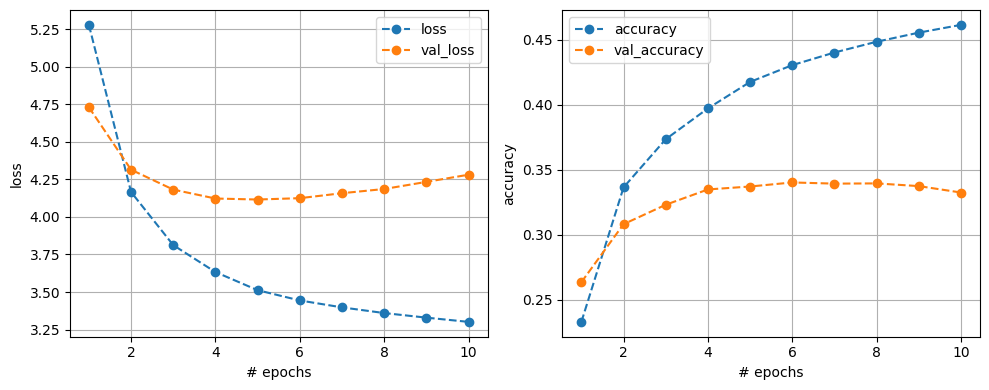

2500/2500 [==============================] - 273s 109ms/step - loss: 3.3011 - accuracy: 0.4613 - val_loss: 4.2814 - val_accuracy: 0.3324 - lr: 0.0010
Entrenamiento completado en 2958.04 segundos
Tiempo promedio por época: 1106.76 segundos


In [106]:
#Entrenamos de nuevo modelo
history = transformer.fit(train_vectorized, epochs=50, validation_data=val_vectorized, callbacks=callbacks)

In [107]:
### Ajustamos el código proporcionado
fr_vocab = fr_vectorization.get_vocabulary()
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
max_decoded_sentence_length = 40


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = fr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

In [96]:
import nltk.translate.bleu_score as bleu

# Define the number of sentences to evaluate
num_sentences = 100

# Function to calculate BLEU score
def calculate_bleu_score(data):
    references = []
    translations = []

    for i in range(num_sentences):
        input_sentence = data[i][0]  # English input sentence
        target_sentence = data[i][1]  # Target (reference) sentence

        print("\n\nInput_sentence:", input_sentence, "\n")
        # Decode the input sentence
        decoded_sentence = decode_sequence(input_sentence)
        
        print(decoded_sentence)

        # Store the reference and translation sentences for BLEU score calculation
        references.append([target_sentence.split()])
        translations.append(decoded_sentence.split())

    # Calculate the BLEU score
    bleu_score = bleu.corpus_bleu(references, translations)

    return bleu_score

# Calculate BLEU score on a subset of the test data
test_subset = test_data[:num_sentences].tolist()
bleu_score = calculate_bleu_score(test_subset)
print("BLEU Score:", bleu_score)



Input_sentence: safety on the south coast  new coast guard station commissioned in burgeo    national defence 

[start] sécurité de la sécurité de la côte du sud de la côte du [UNK] en la côte est [UNK] end


Input_sentence: canada  united states defence relations    national defence 

[start] relations commerciales en matière de commerce international canada end  end end end end end end end end end end


Input_sentence: second world war veteran receives compensation    national defence 

[start] deuxième monde la après [UNK] de la propriété intellectuelle du monde end  end end end end end end end


Input_sentence: air crews engaged in aerial combat resupply drops    national defence 

[start] les membres de la [UNK] de la [UNK] de [UNK] de [UNK] [UNK] end  [UNK] end end end end


Input_sentence: oil and gas prices taxes and consumers tax bulletin     message from her excellency the right honourable michaëlle jean governor general and commanderinchief of canada on the death of major 

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>

Tras las mejoras proporcionadas, hemos subido de un BLEU-Score de 0,025 a uno con 0,089 lo cual ha sido un incremento “aceptable”.
    
Leyendo diversos artículos, en general con esta arquitectura los resultados obtenidos son los esperados, y puede ser que arquitectura es muy simple para este tipo de problemas, por lo que incrementar la estructura añadiendo mas encoder y decoder (en algún artículo ponían 60 encoder y 12 decoder) podría hacer subir el valor del BLEU-score.

<br><br>
</div>